Mounting Drive to get data 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


Installing Dependencies

In [5]:
! pip install mtcnn

     |████████████████████████████████| 2.3MB 9.1MB/s 


In [6]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


**Face Detection**

The function extract_face uses the MTCNN library to detect a face from an image.
We initially convert it to RGB if needed using the PIL library and then run the detect_faces method from MTCNN to get faces. It gives us output which can be used to detect a bounding box. We get the top left corner coordinates, the width and the height of the face. We thus can get the boundary coordinates.
After this, we send the part of the image (i.e. the face) between these coordinatesas our returned array. We also perform a resizing here as the Facenet model used belopw needs images in 160*160 format.

The code snippet below the function basically lists all images in the directory and runs the extract_faces function on it. The results are plotted to show the output that was generated from extract_faces.
In this cell, we run the extract_face function on one face (Ben Affleck) and display its results


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


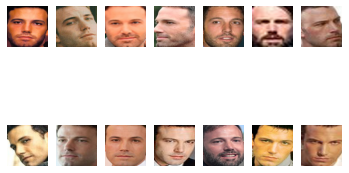

In [7]:
# demonstrate face detection on 5 Celebrity Faces Dataset

from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# specify folder to plot
folder = './gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path,(160, 160))
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()



The detect_face function is the same as above. Here, we run the function on the entire 5 celebrities dataset ( training, validation parts included)
The combined results are stored in an .npz file

In [8]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path,(160, 160))
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


#please replace the path mentioned below with the path of your dataset.
# load train dataset
trainX, trainy = load_dataset('./gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 14 examples for class: ben_afflek
>loaded 12 examples for class: aishwarya
(105, 160, 160, 3) (105,)
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: aishwarya


We are using a face detection algorithm called facenet, open sourced by Google to detect a face. 
The Keras implementation of facenet provides us a pretrained model trained on millions of images in .h5 format
The function get_embeddings uses this model to get the 128-d embeddingsfrom an  input image
We first load the .npz data that we obtained earlier and then load the facenet model. We then oass each image array to the facenet model to get the embddings. We do an expand_dims to shape the input array in the format that the .h5 model needs it in.
Finally, we store the generated embeddings in a .npz file 

In [9]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
modelem = load_model('./gdrive/My Drive/facenet/model/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(modelem, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(modelem, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (105, 160, 160, 3) (105,) (30, 160, 160, 3) (30,)
Loaded Model
(105, 128)
(30, 128)


Here we load the dataset

In [10]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=105, test=30


We run a linear SVM that will classify the embeddings that were generated previously. 
We use a label encoder to help the SVM identidy which celebrity we are considering. We run the label_encoder on the output labels in test and training data to get lablled data. 
The embeddings that we have obtained are normalized and then given to the SVM model to learn. The SVM model gives us the output for a given embedding and the probability with which it predicted the output.
We then show the output for one sample image.


Predicted: elton_john (86.334)
Expected: elton_john


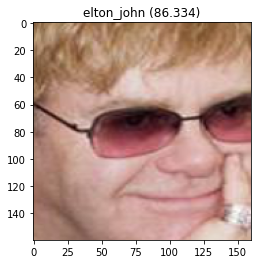

Predicted  elton_john  with probability  86.33425214318842


In [11]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load testing data faces
data2 = load('5-celebrity-faces-dataset.npz')
testX_faces = data2['arr_2']
# load training dataface embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testXem, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testXem)
#print("test embeddings")
#print(testXem)
#print(testXem[0].shape)
#print("test")
#print(testX)
#print(testX.shape)
#print(testX[0].shape)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
modelsvc = SVC(kernel='linear', probability=True)
modelsvc.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
#print("random_face_emb",testX[selection])
#print(testX[selection].shape)
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
#print("samples:",samples)
#print(samples.shape)
yhat_class = modelsvc.predict(samples)
yhat_prob = modelsvc.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
print("Predicted ",predict_names[0]," with probability ",class_probability)

**Emotion Recognition**

Imports are set here

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import keras
from keras.preprocessing import image

from keras import applications as keras_applications

!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

from keras_vggface.vggface import VGGFace
from keras_vggface import utils



     |████████████████████████████████| 51kB 4.3MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-dmf8m9n7
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-dmf8m9n7
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=55f15414766b5d7b672e4fe9bbad12f95ab91b2a3e09c98cb41c9f751e54fdae
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsifhcln/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [13]:
import keras
from keras.preprocessing import image
from keras import applications as keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

**Data Preprocessing**

Here, we read the fer2013 dataset and display it for primary iderstanding of the data

In [14]:
# os.system('tar -xf /kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz');
#please replace the path mentioned below with the path of your fer2013 dataset.
data = pd.read_csv('./gdrive/My Drive/facenet/fer2013/fer2013.csv')
# ./gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/train/
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


We get the train data, test data and the validation data by filtering on the three labels in the usage column( Training, PublicTest amd PrivateTest) respectively The sizes of the dataframes are displayed below

In [15]:
data.Usage.unique()
train_data = data[data.Usage=='Training']
val_data = data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']
train_data.shape, val_data.shape, test_data.shape

((28709, 3), (3589, 3), (3589, 3))

Adding required Imports

In [16]:
!pip install imblearn
import collections
import imblearn
from imblearn import under_sampling, over_sampling
oversampler = imblearn.over_sampling.RandomOverSampler()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Using a counter, we find the count of no of entries for each emotion in the dataset

In [17]:
collections.Counter(train_data.emotion)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965})

We first give the data to an oversampler to balance it across classes. 
After that  just reshape the data so that it can be used in the input.
Note that the oversampling is done on the training data only and not the test and validation data

In [18]:
from keras.utils import to_categorical

x_train, y_train = oversampler.fit_resample(train_data.pixels.values.reshape(-1,1),train_data.emotion.values)

# x_train = train_data.pixels.values.reshape(-1,1)
# y_train = train_data.emotion.values

x_val = val_data.pixels.values.reshape(-1,1)
y_val = val_data.emotion.values

x_test = test_data.pixels.values.reshape(-1,1)
y_test = test_data.emotion.values

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


We use a counter to show that the data is now evenly sampled across various emotions

In [19]:
collections.Counter(y_train)

Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215, 6: 7215})

We create one hot vectors of output vectors here using the to_categorical method on test and validation labels

In [20]:
y_train = to_categorical(y_train,num_classes=7)
y_val   = to_categorical(y_val  ,num_classes=7)
y_test  = to_categorical(y_test ,num_classes=7)

We apply label smoothing on the one hot encoded vectors. Label smoothing operation is in many ways similar to regularization. It reduces the gap between elements in logit vectors , resulting in better predictions.
A requisite for label smoothing is that the output layer should use the loss function as cross entropy and softmax in the penultimate layers
For k classes, the smoothened output is as follows: 

y_ls = (1 - α) * y_hot + α / K

Here, α is the smoothing factor between 0 to 1

In [21]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

**Data Loader**

Here, we define a custom data loader that will feed the emotion detection model data in batches of 128 images. 
The \__len__ , \__get_item__ and on_epoch_end methods are inline with the concepts of data loader. We are skipping the concepts of data loader here for the sake of brevity

In [22]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

The train, test and validation data are stored as arrays of length (48,48,1)

In [23]:
x_train = list(x_train)
x_val   = list(x_val)
x_test  = list(x_test)

for i,item in enumerate(x_train):
    x_train[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_val):
    x_val[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_test):
    x_test[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
 
x_train = np.vstack(x_train).reshape(-1,48,48,1)
x_val = np.vstack(x_val).reshape(-1,48,48,1)
x_test = np.vstack(x_test).reshape(-1,48,48,1)

In [24]:
train_sequence = data_sequence(x_train,y_train,batch_size=16,target_dim=(224,224),n_classes=7,shuffle=False)
feature,lable = train_sequence.__getitem__(0)
print(train_sequence)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted emotion Angry


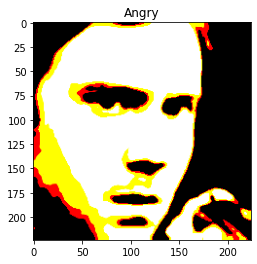

In [25]:
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

import matplotlib.pyplot as plt
plt.imshow(feature[0,:,:,:])
plt.title(emotion_dict[np.argmax(lable[0])]);
print("Predicted emotion",emotion_dict[np.argmax(lable[0])])


**A brief summary of our VGGface Resnet50 Model**

In [26]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
vggface.summary()

94699520/94694792 [==============================] - 3s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_448 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_448[0][0]                  
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________

In [27]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

emotionalmodel = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_298 (Flatten)        (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1043 (Dense)           (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1044 (Dense)           (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                 7

**Creating a train,test and validation data sequence using the data loader defined earlier**

In [28]:
train_sequence = data_sequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(x_val,  y_val,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

**Hyper Parameter Tuning**

**Training the model over 5 epochs and Default Learning Rate**

Epoch 1/5
789/789 [==============================] - 133s 169ms/step - loss: 0.5727 - accuracy: 0.7971 - val_loss: 1.0780 - val_accuracy: 0.6334
Epoch 2/5
789/789 [==============================] - 131s 166ms/step - loss: 0.5178 - accuracy: 0.8169 - val_loss: 1.0876 - val_accuracy: 0.6398
Epoch 3/5
789/789 [==============================] - 125s 159ms/step - loss: 0.4750 - accuracy: 0.8329 - val_loss: 1.1182 - val_accuracy: 0.6401
Epoch 4/5
789/789 [==============================] - 123s 156ms/step - loss: 0.4214 - accuracy: 0.8532 - val_loss: 1.0911 - val_accuracy: 0.6490
Epoch 5/5
789/789 [==============================] - 122s 155ms/step - loss: 0.4090 - accuracy: 0.8569 - val_loss: 1.1817 - val_accuracy: 0.6560


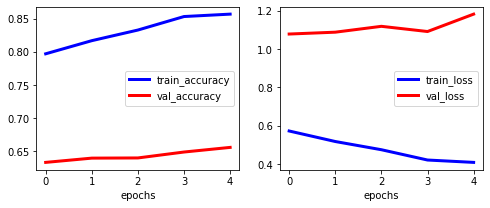

In [31]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
hist = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], marker='', color='blue', linewidth=3,label="train_accuracy")
plt.plot(hist.history['val_accuracy'], marker='', color='red', linewidth=3,label="val_accuracy")
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],marker='', color='blue', linewidth=3,label="train_loss")
plt.plot(hist.history['val_loss'],marker='', color='red', linewidth=3,label="val_loss")
plt.xlabel('epochs')
plt.legend()


**Training the model over 5 epochs and Learning Rate= 1e-4**

Epoch 1/5
789/789 [==============================] - 132s 167ms/step - loss: 1.3126 - accuracy: 0.5431 - val_loss: 1.1045 - val_accuracy: 0.5834
Epoch 2/5
789/789 [==============================] - 128s 162ms/step - loss: 0.8899 - accuracy: 0.6752 - val_loss: 1.0266 - val_accuracy: 0.6211
Epoch 3/5
789/789 [==============================] - 125s 158ms/step - loss: 0.7215 - accuracy: 0.7403 - val_loss: 1.0134 - val_accuracy: 0.6390
Epoch 4/5
789/789 [==============================] - 123s 156ms/step - loss: 0.6099 - accuracy: 0.7814 - val_loss: 0.9787 - val_accuracy: 0.6462
Epoch 5/5
789/789 [==============================] - 124s 157ms/step - loss: 0.5080 - accuracy: 0.8193 - val_loss: 0.9861 - val_accuracy: 0.6585


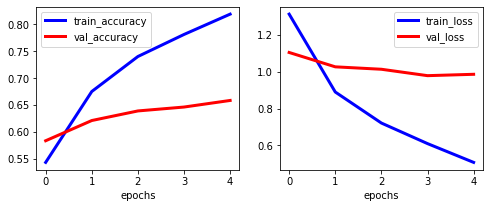

In [32]:
emotionalmodel2 = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel2.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = emotionalmodel2.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'], marker='', color='blue', linewidth=3,label="train_accuracy")
plt.plot(hist2.history['val_accuracy'], marker='', color='red', linewidth=3,label="val_accuracy")
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist2.history['loss'],marker='', color='blue', linewidth=3,label="train_loss")
plt.plot(hist2.history['val_loss'],marker='', color='red', linewidth=3,label="val_loss")
plt.xlabel('epochs')
plt.legend()

**Training the model over 5 epochs and Learning Rate= 1e-5**

Epoch 1/5
789/789 [==============================] - 123s 156ms/step - loss: 2.0058 - accuracy: 0.3575 - val_loss: 1.4362 - val_accuracy: 0.4858
Epoch 2/5
789/789 [==============================] - 122s 154ms/step - loss: 1.4166 - accuracy: 0.5005 - val_loss: 1.2919 - val_accuracy: 0.5268
Epoch 3/5
789/789 [==============================] - 119s 151ms/step - loss: 1.2439 - accuracy: 0.5519 - val_loss: 1.2199 - val_accuracy: 0.5499
Epoch 4/5
789/789 [==============================] - 119s 151ms/step - loss: 1.1428 - accuracy: 0.5840 - val_loss: 1.1818 - val_accuracy: 0.5617
Epoch 5/5
789/789 [==============================] - 119s 151ms/step - loss: 1.0534 - accuracy: 0.6140 - val_loss: 1.1543 - val_accuracy: 0.5739


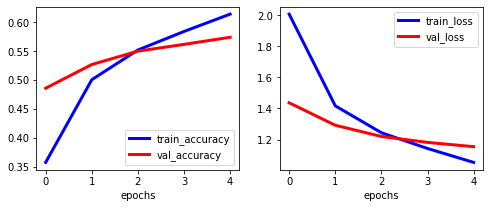

In [33]:
emotionalmodel3 = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel3.compile(optimizer = keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = emotionalmodel3.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist3.history['accuracy'], marker='', color='blue', linewidth=3,label="train_accuracy")
plt.plot(hist3.history['val_accuracy'], marker='', color='red', linewidth=3,label="val_accuracy")
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist3.history['loss'],marker='', color='blue', linewidth=3,label="train_loss")
plt.plot(hist3.history['val_loss'],marker='', color='red', linewidth=3,label="val_loss")
plt.xlabel('epochs')
plt.legend()

**As we can observe from the above above cells that the model with lr=1e-04 has the best  accuracies and least losses. So we are going to chose Learning Rate to be 1e-4 and now train model for different number of epochs to avoid overfitting and see if there is a possibility of early stopping.**

**Training the model over 10 epochs and Learning Rate= 1e-4**

Epoch 1/10
789/789 [==============================] - 123s 156ms/step - loss: 1.3144 - accuracy: 0.5408 - val_loss: 1.1208 - val_accuracy: 0.5862
Epoch 2/10
789/789 [==============================] - 120s 152ms/step - loss: 0.8767 - accuracy: 0.6813 - val_loss: 1.0364 - val_accuracy: 0.6214
Epoch 3/10
789/789 [==============================] - 120s 152ms/step - loss: 0.7173 - accuracy: 0.7419 - val_loss: 1.0230 - val_accuracy: 0.6370
Epoch 4/10
789/789 [==============================] - 118s 150ms/step - loss: 0.5988 - accuracy: 0.7859 - val_loss: 0.9878 - val_accuracy: 0.6482
Epoch 5/10
789/789 [==============================] - 116s 147ms/step - loss: 0.5055 - accuracy: 0.8216 - val_loss: 0.9914 - val_accuracy: 0.6582
Epoch 6/10
789/789 [==============================] - 116s 147ms/step - loss: 0.4317 - accuracy: 0.8475 - val_loss: 1.0233 - val_accuracy: 0.6532
Epoch 7/10
789/789 [==============================] - 117s 148ms/step - loss: 0.3724 - accuracy: 0.8700 - val_loss: 1.0183 -

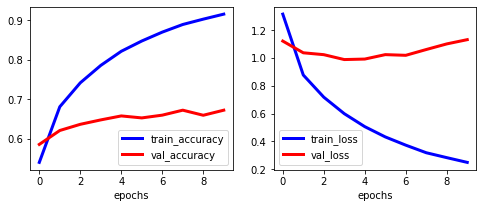

In [34]:
emotionalmodel4 = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel4.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist4 = emotionalmodel4.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist4.history['accuracy'], marker='', color='blue', linewidth=3,label="train_accuracy")
plt.plot(hist4.history['val_accuracy'], marker='', color='red', linewidth=3,label="val_accuracy")
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist4.history['loss'],marker='', color='blue', linewidth=3,label="train_loss")
plt.plot(hist4.history['val_loss'],marker='', color='red', linewidth=3,label="val_loss")
plt.xlabel('epochs')
plt.legend()

**Training the model over 20 epochs and Learning Rate= 1e-4**

Epoch 1/20
789/789 [==============================] - 126s 160ms/step - loss: 1.3137 - accuracy: 0.5405 - val_loss: 1.0946 - val_accuracy: 0.5907
Epoch 2/20
789/789 [==============================] - 124s 157ms/step - loss: 0.8852 - accuracy: 0.6780 - val_loss: 1.0489 - val_accuracy: 0.6194
Epoch 3/20
789/789 [==============================] - 125s 159ms/step - loss: 0.7238 - accuracy: 0.7376 - val_loss: 1.0115 - val_accuracy: 0.6345
Epoch 4/20
789/789 [==============================] - 125s 159ms/step - loss: 0.5995 - accuracy: 0.7876 - val_loss: 0.9871 - val_accuracy: 0.6507
Epoch 5/20
789/789 [==============================] - 121s 154ms/step - loss: 0.5063 - accuracy: 0.8212 - val_loss: 1.0138 - val_accuracy: 0.6521
Epoch 6/20
789/789 [==============================] - 121s 153ms/step - loss: 0.4252 - accuracy: 0.8523 - val_loss: 1.0208 - val_accuracy: 0.6551
Epoch 7/20
789/789 [==============================] - 122s 154ms/step - loss: 0.3655 - accuracy: 0.8728 - val_loss: 1.0404 -

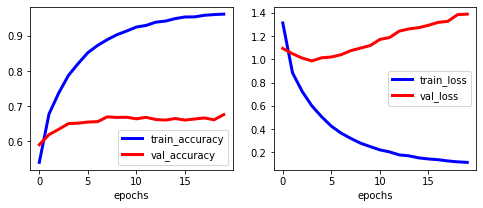

In [36]:
emotionalmodel5 = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel5.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist5 = emotionalmodel5.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 20)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist5.history['accuracy'], marker='', color='blue', linewidth=3,label="train_accuracy")
plt.plot(hist5.history['val_accuracy'], marker='', color='red', linewidth=3,label="val_accuracy")
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist5.history['loss'],marker='', color='blue', linewidth=3,label="train_loss")
plt.plot(hist5.history['val_loss'],marker='', color='red', linewidth=3,label="val_loss")
plt.xlabel('epochs')
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


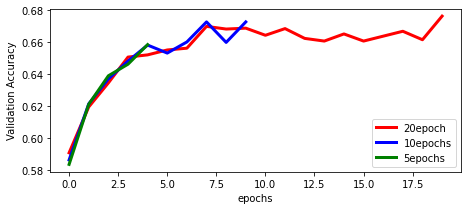

In [37]:
plt.figure(figsize=(25,3))
plt.subplot(1,3,1)
plt.plot(hist5.history['val_accuracy'], marker='', color='red', linewidth=3,label="20epoch")
plt.subplot(1,3,1)
plt.plot(hist4.history['val_accuracy'], marker='', color='blue', linewidth=3,label="10epochs")
plt.subplot(1,3,1)
plt.plot(hist2.history['val_accuracy'], marker='', color='green', linewidth=3,label="5epochs")
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

**From our observations above we have decided that we will be using the best model that gives max accuracies and least losses in both training and testing which is model with learning rate= 1e-4 and epoch=10**

In [38]:
emotionalmodel4.evaluate(test_sequence)

56/56 [==============================] - 8s 139ms/step - loss: 1.0466 - accuracy: 0.6828


[1.046642541885376, 0.6827567219734192]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Expected emotion: Happy
Predicted Emotion: Happy with probabiltity: 0.9984205


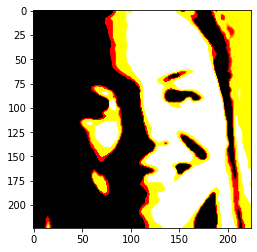

In [39]:
feature2,lable2 = test_sequence.__getitem__(0)
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

import matplotlib.pyplot as plt
plt.imshow(feature2[4,:,:,:])
print("Expected emotion:",emotion_dict[np.argmax(lable2[4])])
res=emotionalmodel4.predict(feature2)
print("Predicted Emotion:",emotion_dict[np.argmax(res[4])],"with probabiltity:",res[4][np.argmax(res[4])])


**Confusion matrix**

In [40]:
import tensorflow as tf
y_pred = []
y_true = []
for x,y in test_sequence:
    y_pred = y_pred + list(emotionalmodel4.predict_classes(x))
    y_true = y_true + list(np.argmax(y,axis=1))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [41]:
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = emotion_dict.values(), 
                                columns = emotion_dict.values())

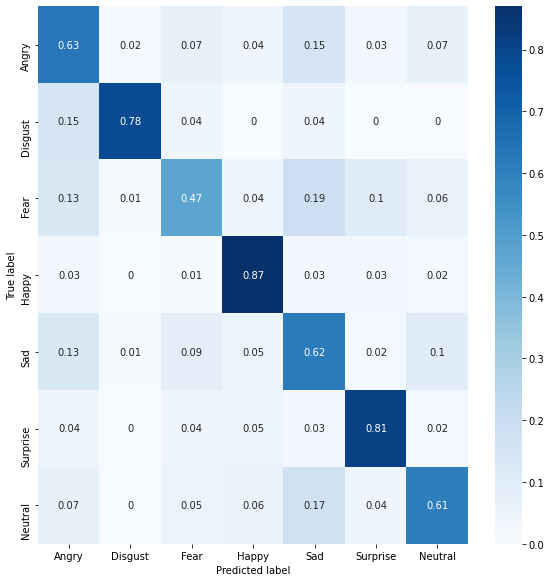

In [42]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Testing on an arbitary images**

This function converts the input images to the format required by the model and predicts the person and their emotion.

In [78]:
def pred(image):
  #face recognition
  image2 = cv2.imread(image)
  image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
  plt.imshow(image2)
  plt.show()
  facearray=extract_face(image,(160, 160))
  embedding2 = get_embedding(modelem, facearray)
  li=[]
  li.append(embedding2)
  in_encoder = Normalizer(norm='l2')
  random_face_emb2 = in_encoder.transform(li)
  samples2 = expand_dims(random_face_emb2[0], axis=0)
  yhat_class2 = modelsvc.predict(samples2)
  yhat_prob2 = modelsvc.predict_proba(samples)
  class_index2 = yhat_class2[0]
  predict_names2 = out_encoder.inverse_transform(yhat_class2)

  #emotion detection
  facearrayem=extract_face(image,(224, 224))
  facearrayem = facearrayem.astype('float32')
  X = utils.preprocess_input(facearrayem, version=2) # or version=2 for VGGFace2 ResNet50  
  X = np.array(X)
  ls=np.array([X])
  res2=emotionalmodel4.predict(ls)
  pyplot.imshow(facearray)
  pyplot.show()
  print(predict_names2[0],"is feeling",emotion_dict[np.argmax(res2[0])],"today")
  print("Face Recognition probability:",yhat_prob2[0][np.argmax(yhat_prob2)],"Emotion Detection probability:",res2[0][np.argmax(res2[0])])

**Let us try our model on a few images**

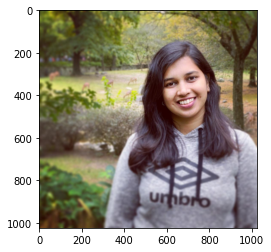

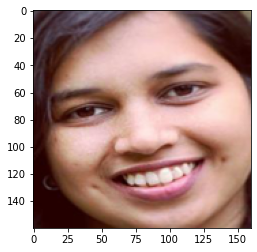

aishwarya is feeling Happy today
Face Recognition probability: 0.8633425214318842 Emotion Detection probability: 0.9998975


In [79]:
#enter the path of the image that you would want to test for face recognition and  emotion detection
pred('/content/gdrive/MyDrive/facenet/images/5-celebrity-faces-dataset/aishwarya.jpeg')

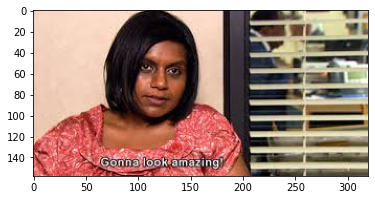

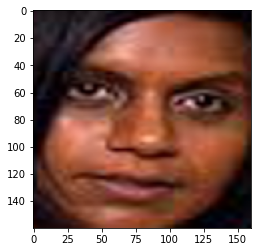

mindy_kaling is feeling Angry today
Face Recognition probability: 0.8633425214318842 Emotion Detection probability: 0.6486902


In [80]:
pred('/content/gdrive/MyDrive/facenet/images/5-celebrity-faces-dataset/mindyangry.jpg')

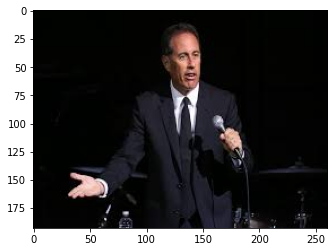

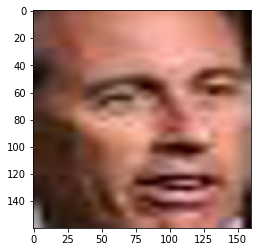

jerry_seinfeld is feeling Sad today
Face Recognition probability: 0.8633425214318842 Emotion Detection probability: 0.8394865


In [81]:
pred('/content/gdrive/MyDrive/facenet/images/5-celebrity-faces-dataset/jerry2.jpg')

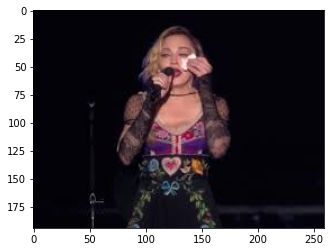

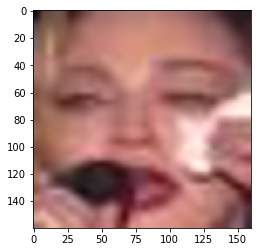

madonna is feeling Sad today
Face Recognition probability: 0.8633425214318842 Emotion Detection probability: 0.27696502


In [82]:
pred('/content/gdrive/MyDrive/facenet/images/5-celebrity-faces-dataset/madonnacry.jpg')